In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv, datetime, os
import matplotlib.dates as mdates
import pandas as pd
from sklearn.metrics import r2_score
import pandas as pd
# from tqdm import tqdm


def MakeDataFromText(filepath:str):
    """
    Helper function to parse text files in IFM proprietary format.
    """
    with open(filepath, 'r') as file:
        reader = csv.reader(file)

        db = dict()                          # Dictionary that will hold k,v pairs of 
        recent_EPC = ''                      # The most recent EPC that was read, and data is being assigned to
        Time_Or_Data = True                  # Time is true, Data is false
        reached_24 = False

        for l in reader:                     # Iterate over entire text file
            line = l[0]                      # Each line only has one token, so we select it
            
            if len(line)==24:                # If it is an EPC
                db[line] = [[],[]]           # Create new k,v pair in database
                recent_EPC = line            # Current EPC to add to is selected
            
            elif line == '[':                # If start bracket, beginning to collect an array of data
                data = []

            elif line == ']':                # End bracket means end of data array
                if len(data)!=0:
                    if Time_Or_Data:
                        db[recent_EPC][0] = data
                        Time_Or_Data = False
                    else:
                        db[recent_EPC][1] = data
                        Time_Or_Data = True
                data = []

            elif line.count(":")==2:
                h,m,s = line.split(':')      # Parse timestamp into hours, minutes, seconds

                if int(h)==23:
                    reached_24 = True        # If end of day reached, must move to Day 2

                if reached_24 and int(h) < 12:
                    day=2
                else:
                    day=1

                data.append(datetime.datetime(1970, 2, day, int(h), int(m), int(s)))
            
            elif line ==' ':               # If blank space, then we skip to parse next line
                pass

            else:                          # If it is a data point
                try:
                    data.append(float(line))
                except:
                    pass                   # Error catching case just in case, so annoying errors don't crash program
    return db


def MakeDict(data:list):
    """
    """
    t1234 = dict()
    for d in data:
        for k,v in d.items():
            if k in t1234: # if tag is already in dict
                for i in range(len(v[0])):
                    if v[0][i] in t1234[k]:
                        t1234[k][v[0][i]].append(v[1][i])
                    else:
                        t1234[k][v[0][i]] = [v[1][i]]
            else:             # if tag is not in dict
                t1234[k] = dict()
                for i in range(len(v[0])):
                    t1234[k][v[0][i]] = [v[1][i]]
    for k,v in t1234.items():
        for k2,v2 in v.items():
            t1234[k][k2] = sum(v2)/len(v2)
    return t1234

c:\Users\trevo\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# rssi = MakeDict([MakeDataFromText('CHANGING/91430/RSSI_91430.csv')])
# temp = MakeDict([MakeDataFromText('CHANGING/91430/tags_91430.csv')])

# rssi = MakeDict( [MakeDataFromText('CHANGING/05092023 1746 Temp offset/RSSI_56172.csv')] )
# temp = MakeDict( [MakeDataFromText('CHANGING/05092023 1746 Temp offset/tags_56172.csv')] )

rssi = MakeDict( [MakeDataFromText('CHANGING/5162023 1320 start/RSSI_69145.csv')] )
temp = MakeDict( [MakeDataFromText('CHANGING/5162023 1320 start/tags_69145.csv')] )

# rssi = MakeDict( [MakeDataFromText('DATA/05032023 1750 33.3/RSSI_99979.csv')] )
# temp = MakeDict( [MakeDataFromText('DATA/05032023 1750 33.3/tags_99979.csv')] )

# rssi = MakeDict( [MakeDataFromText('DATA/05032023 1830 33.4/RSSI_77219.csv')] )
# temp = MakeDict( [MakeDataFromText('DATA/05032023 1830 33.4/tags_77219.csv')] )

In [3]:
water = pd.read_csv( 'CHANGING/05092023 1746 Temp offset/water data 05-08-23.csv', skiprows=0, sep=',', header=0 )

water.columns = [ 'Timestamp', 'Serial Number', 'Channel', 'Data', 'Unit of Measure' ]
water = water.iloc[:48]

s1_time, s1_data, s2_time, s2_data = [], [], [], []

for i in range(42):
    _,hms = water['Timestamp'][i].split(' ')
    h,m = hms.split(':')
    time = datetime.datetime(1970, 2, 1, int(h[-2:]), int(m), 0)

    if water['Channel'][i]==1:
        s1_data.append(water['Data'][i])
        s1_time.append(time)
    
    elif water['Channel'][i]==2:
        s2_data.append(water['Data'][i])
        s2_time.append(time)

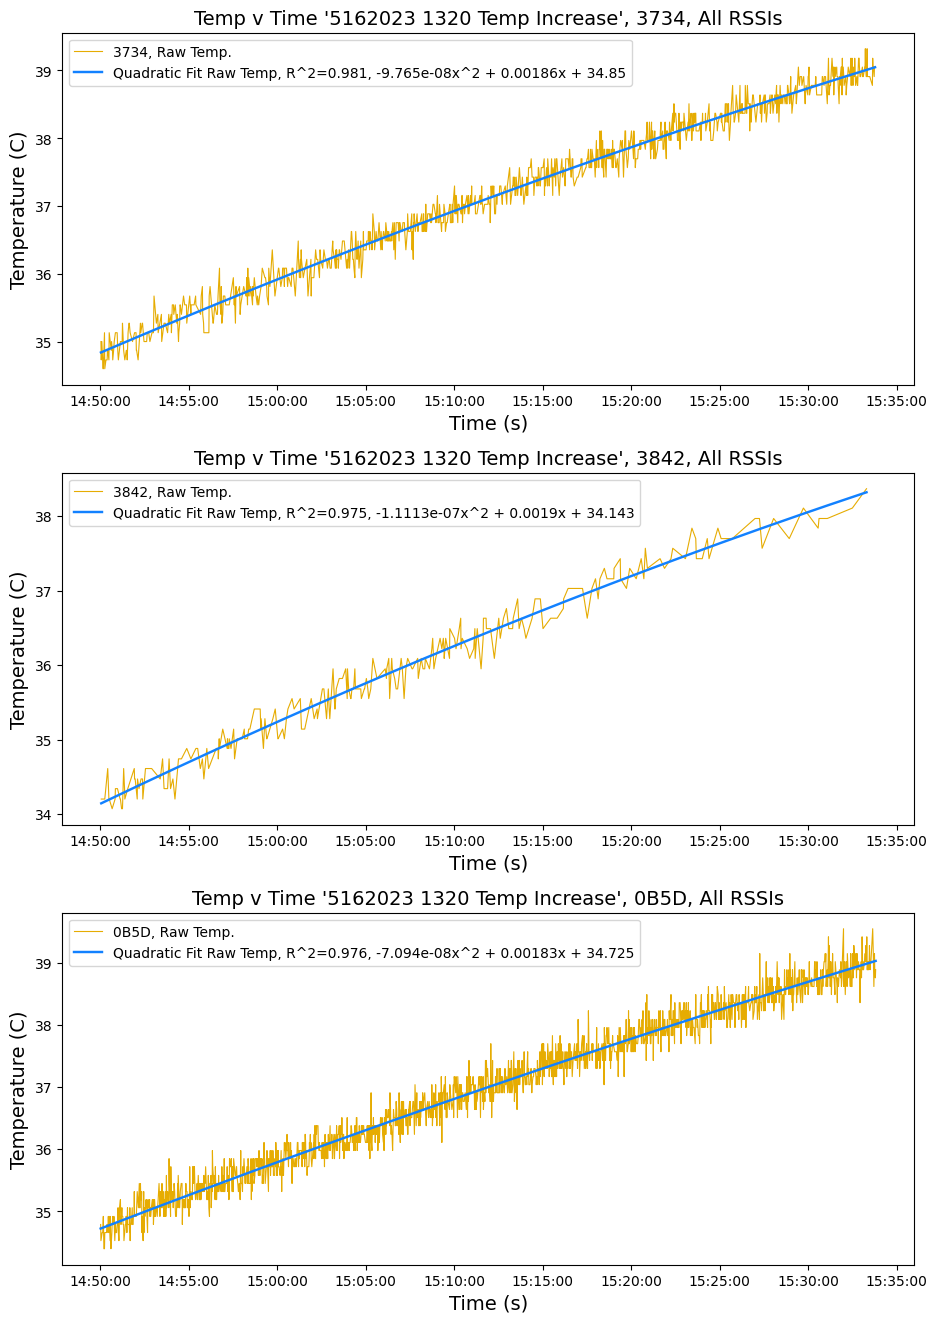

In [8]:
fig, (ax1,ax2, ax3) = plt.subplots(3, 1, figsize=(11, 16), sharex=True)
fig.subplots_adjust(hspace=0.25)
axs = [ ax1, ax2, ax3 ]

for a__ in axs: 
    a__.xaxis.set_major_formatter( mdates.DateFormatter('%H:%M:%S') )
    a__.tick_params(labelbottom=True)

# ax1.set_xlim( [datetime.datetime(1970, 2, 1, 17, 45, 0), datetime.datetime(1970, 2, 1, 19, 16, 0)] )
# TAGS = [ '2B42', '3242', '3943' ]
TAGS = [ '3734', '3842', '0B5D' ]

for i in range(3):
    for k,v in temp.items():
        if k[-4:]==TAGS[i]:
            st, sr = sorted(temp[k].items()), sorted(rssi[k].items())
            dt = [j[1] for j in st if j[0]<datetime.datetime(1970, 2, 1, 15, 35, 0)and j[0]>datetime.datetime(1970, 2, 1, 14, 50, 0) ]
            tt = [j[0] for j in st if j[0]<datetime.datetime(1970, 2, 1, 15, 35, 0)and j[0]>datetime.datetime(1970, 2, 1, 14, 50, 0) ]
            dr = [j[1] for j in sr if j[0]<datetime.datetime(1970, 2, 1, 15, 35, 0)and j[0]>datetime.datetime(1970, 2, 1, 14, 50, 0) ]
            
            # new_dt, new_tt = [], []
            # for p in range(len(dr)):
            #     actual = 0.0
            #     if i==0:    actual = 0.032 * (9.83  - float(dr[p])) + float(dt[p]) + 0.6368;
            #     elif i==1:  actual = 0.037 * (22.53 - float(dr[p])) + float(dt[p]) + 0.5043;
            #     elif i==2:  actual = 0.048 * (2.84  - float(dr[p])) + float(dt[p]) + 1.0122;
            #     new_dt.append(actual); new_tt.append(tt[p])

            # axs[i].plot(s1_time, s1_data, label='Raw Water Temp, Sensor 1', linewidth=1.5, color="#048CF9", marker=".")
            # axs[i].plot(s2_time, s2_data, label='Raw Water Temp, Sensor 2', linewidth=1.5, color="#012AB3", marker=".")
            axs[i].plot(tt, dt, label=TAGS[i] + ", Raw Temp.", linewidth=0.8, color="#E6AC02")
            # axs[i].plot(new_tt, new_dt, label=TAGS[i] + ", Actual Temp. Equation", linewidth=0.8, color="#d10101")

            if True:
                __t = np.array([ (j___ - tt[0]).total_seconds() for j___ in tt ])
                model2_ = np.poly1d( np.polyfit(__t, dt,  2) )
                strmodel2_ = ", " + str(round(model2_[2], 11))+"x^2 + "+str(round(model2_[1], 5))+"x + "+str(round(model2_[0], 3))
                y2_r2_ = r2_score(dt, model2_(__t))
                axs[i].plot(tt, model2_(__t), label='Quadratic Fit Raw Temp, R^2='+str(round(y2_r2_, 3))+strmodel2_, linewidth=1.75, color="#1281FF")

                # _t = np.array([ (j___ - new_tt[0]).total_seconds() for j___ in tt ])
                # model2 = np.poly1d( np.polyfit(_t, new_dt,  2) )
                # strmodel2 = ", " + str(round(model2[2], 11))+"x^2 + "+str(round(model2[1], 5))+"x + "+str(round(model2[0], 3))
                # y2_r2 = r2_score(new_dt, model2(_t))
                # axs[i].plot(new_tt, model2(_t), label='Quadratic Fit on Actual, R^2='+str(round(y2_r2, 4))+strmodel2, linewidth=0.9, color="#d10101")

                # _s1t = [ (j-s1_time[0]).total_seconds() for j in s1_time ]
                # _s2t = [ (j-s2_time[0]).total_seconds() for j in s2_time ]
                # models1 = np.poly1d( np.polyfit(_s1t, s1_data,  2) )
                # models2 = np.poly1d( np.polyfit(_s2t, s2_data,  2) )
                # strs1 = ", " + str(round(models1[2], 11))+"x^2 + "+str(round(models1[1], 5))+"x + "+str(round(models1[0], 3))
                # strs2 = ", " + str(round(models2[2], 11))+"x^2 + "+str(round(models2[1], 5))+"x + "+str(round(models2[0], 3))
                # y2_s1, y2_s2 = r2_score(s1_data, models1(_s1t)), r2_score(s2_data, models2(_s2t))
                # axs[i].plot(s1_time, models1(_s1t), label='Water Sensor 1 Fit, R^2='+str(round(y2_s1, 4))+strs1, linewidth=0.7, color="#1281ff")
                # axs[i].plot(s2_time, models2(_s2t), label='Water Sensor 2 Fit, R^2='+str(round(y2_s2, 4))+strs2, linewidth=0.7, color="#00056b")

                # axs[i].plot(s1_time, s1_data, marker=".", linewidth=0.15, color="#FCC603")
                # axs[i].plot(s2_time, s2_data, marker=".", linewidth=0.15, color="#FCC603")
            
            axs[i].set_ylabel('Temperature (C)', fontsize=14)
            axs[i].set_xlabel('Time (s)', fontsize=14)
            axs[i].set_title('Temp v Time \'5162023 1320 Temp Increase\', ' + TAGS[i] + ", All RSSIs", fontsize=14)
            axs[i].legend()

0 0


TypeError: expected non-empty vector for x

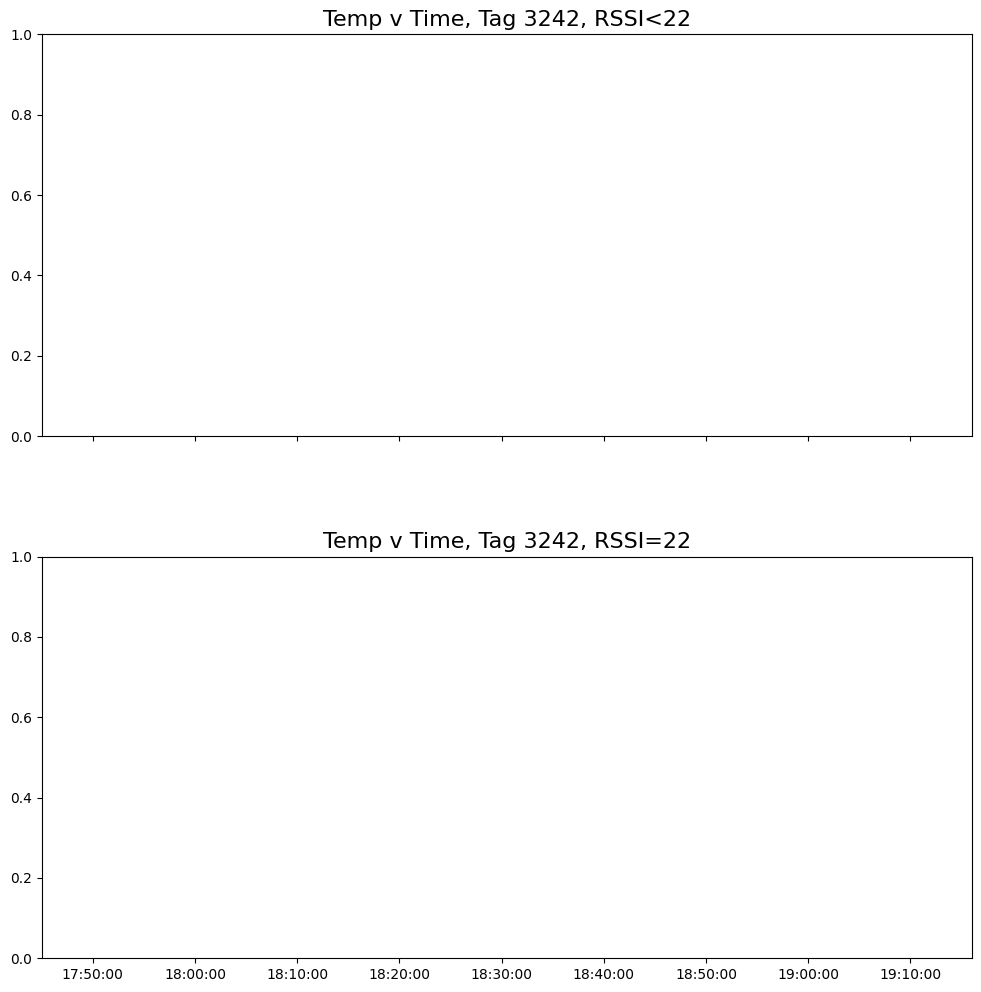

In [5]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
fig.subplots_adjust(hspace=0.3)
axs = [ ax1, ax2 ]

for a__ in axs: a__.xaxis.set_major_formatter( mdates.DateFormatter('%H:%M:%S') )

ax1.set_xlim( [datetime.datetime(1970, 2, 1, 17, 45, 0), datetime.datetime(1970, 2, 1, 19, 16, 0)] )
axs[0].set_title('Temp v Time, Tag 3242, RSSI<22', fontsize=16)
axs[1].set_title('Temp v Time, Tag 3242, RSSI=22', fontsize=16)
TAGS = [ "3242", "3242" ]

for i in range(2):
    for k,v in temp.items():
        if k[-4:]==TAGS[i]:
            st, sr = sorted(temp[k].items()), sorted(rssi[k].items())
            dt = [j[1] for j in st if j[0] > datetime.datetime(1970, 2, 1, 17, 45, 57)]
            tt = [j[0] for j in st if j[0] > datetime.datetime(1970, 2, 1, 17, 45, 57)]
            dr = [j[1] for j in sr if j[0] > datetime.datetime(1970, 2, 1, 17, 45, 57)]
            
            new_dt, new_tt = [], []
            for p in range(len(dr)):
                if i==0 and dr[p]<22:
                    actual = 0.037 * (22.53 - float(dr[p])) + float(dt[p]) + 0.5043;
                    new_dt.append(actual)
                    new_tt.append(tt[p])
                if i==1 and dr[p]==22:
                    actual = 0.037 * (22.53 - float(dr[p])) + float(dt[p]) + 0.5043;
                    new_dt.append(actual)
                    new_tt.append(tt[p])


            if True:
                _t = np.array([ (j___ - new_tt[0]).total_seconds() for j___ in new_tt ])
                print(len(_t), len(new_dt))
                model2 = np.poly1d( np.polyfit(_t, new_dt,  2) )
                strmodel2 = ", " + str(round(model2[2], 11))+"x^2 + "+str(round(model2[1], 5))+"x + "+str(round(model2[0], 3))
                y2_r2 = r2_score(new_dt, model2(_t))
                axs[i].plot(new_tt, model2(_t), label='Quadratic Fit on Actual, R^2='+str(round(y2_r2, 4))+strmodel2, linewidth=0.9, color="#d10101")

                _s1t = [ (j-s1_time[0]).total_seconds() for j in s1_time ]
                _s2t = [ (j-s2_time[0]).total_seconds() for j in s2_time ]
                models1 = np.poly1d( np.polyfit(_s1t, s1_data,  2) )
                models2 = np.poly1d( np.polyfit(_s2t, s2_data,  2) )
                strs1 = ", " + str(round(models1[2], 11))+"x^2 + "+str(round(models1[1], 5))+"x + "+str(round(models1[0], 3))
                strs2 = ", " + str(round(models2[2], 11))+"x^2 + "+str(round(models2[1], 5))+"x + "+str(round(models2[0], 3))
                y2_s1, y2_s2 = r2_score(s1_data, models1(_s1t)), r2_score(s2_data, models2(_s2t))
                axs[i].plot(s1_time, models1(_s1t), label='Water Sensor 1 Fit, R^2='+str(round(y2_s1, 4))+strs1, linewidth=0.7, color="#1281ff")
                axs[i].plot(s2_time, models2(_s2t), label='Water Sensor 2 Fit, R^2='+str(round(y2_s2, 4))+strs2, linewidth=0.7, color="#00056b")

            
            axs[i].set_ylabel('Temperature (C)', fontsize=14)
            axs[i].set_xlabel('Time (s)', fontsize=14)
            axs[i].legend()